# Applied Data Science Capstone Project

This notebook will be used for the IBM capstone project.

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["axes.labelsize"] = 13 # set axes label size in all matplotlib plots
plt.rcParams["xtick.labelsize"] = 12 # set axes label size in all matplotlib plots
plt.rcParams["ytick.labelsize"] = 11 # set axes label size in all matplotlib plots
plt.rcParams["axes.titlesize"] = 14 # set axes label size in all matplotlib plots

%matplotlib inline

The collisions dataframe can be download [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)

Metadata about the dataframe can be found [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)

In [4]:
Collisions_df = pd.read_csv("Data-Collisions.csv")
Collisions_df.head(2)

C:\Users\timot\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N


In [5]:
# add time attributes to the dataframe
# get hour of incident and add 12 if it is PM.
Collisions_df["HOUR"] = pd.to_numeric(Collisions_df['INCDTTM'].str.split(" ").str[1].str.split(":").str[0])+12*Collisions_df['INCDTTM'].str.contains("PM")
# extract the month from the INCDTTM column and add to date frame
Collisions_df["MONTH"] = Collisions_df['INCDTTM'].str.split("/").str[0].astype(int)
# extract the year from the INCDTTM column and add to date frame
Collisions_df["YEAR"] = Collisions_df['INCDTTM'].str.split(" ").str[0].str[-4:]

## Data Cleaning

Because of the high degree of overlap between the ADDRTYPE and JUNCTIONTYPE only JUNCTIONTYPE will be included.

In [6]:
Attributes = ['COLLISIONTYPE', 'INATTENTIONIND', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', "HOUR"]

There are some signficant differences in the number of enteries between attributes.
with large absences for INATTENTIONIND and SPEEDING.


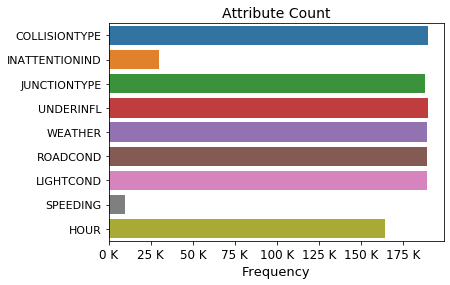

In [7]:
Attribute_count = Collisions_df[Attributes].describe(include="all").transpose()["count"]
Attribute_count_plot = sns.barplot(Attribute_count.values,Attribute_count.index)

xlabels = ['{:,.0f}'.format(x) + ' K' for x in Attribute_count_plot.get_xticks()/1000]
Attribute_count_plot.set_xticklabels(xlabels)
plt.title("Attribute Count")
plt.xlabel("Frequency")

print("There are some significant differences in the number of entries between attributes\
with large absences for INATTENTIONIND and SPEEDING.")

In [8]:
print('\033[1m' + "\nNumber of missing enteries for each attribute:" + '\033[0m') # \033[1m'  '\033[0m' create bold region of text
Collisions_df[Attributes].isna().sum()


Number of missing enteries for each attribute:


COLLISIONTYPE       4904
INATTENTIONIND    164868
JUNCTIONTYPE        6329
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
SPEEDING          185340
HOUR               30526
dtype: int64

In [9]:
print('\033[1m' + "\nUnique enteries for each attribute:\n" + '\033[0m') # \033[1m'  '\033[0m' create bold region of text

for x in Attributes:
    print('\033[1m' + x + ':\033[0m' + "\tTotal enteries:", Collisions_df[x].value_counts().sum())
    print(Collisions_df[x].value_counts(),"\n")
    


Unique enteries for each attribute:

COLLISIONTYPE:	Total enteries: 189769
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64 

INATTENTIONIND:	Total enteries: 29805
Y    29805
Name: INATTENTIONIND, dtype: int64 

JUNCTIONTYPE:	Total enteries: 188344
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64 

UNDERINFL:	Total enteries: 189789
N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64 

WEA

**For the following attribute some instances are labelled as unknown:**

JUNCTIONTYPE, WEATHER, ROADCOND, LIGHTCOND (incl Dark - Unknown Lighting)

This label adds no information and so will be replaced by nan and dropped from the dataframe.

### Removing Unknowns

In [10]:
Collisions_df.replace("Unknown", np.nan, regex=True, inplace = True)

print('\033[1m' + "\nUnique enteries for each attribute:\n" + '\033[0m') # \033[1m'  '\033[0m' create bold region of text

for x in Attributes:
    print('\033[1m' + x + ':\033[0m' + "\tTotal enteries:", Collisions_df[x].value_counts().sum())
    print(Collisions_df[x].value_counts(),"\n")


Unique enteries for each attribute:

COLLISIONTYPE:	Total enteries: 189769
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64 

INATTENTIONIND:	Total enteries: 29805
Y    29805
Name: INATTENTIONIND, dtype: int64 

JUNCTIONTYPE:	Total enteries: 188335
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Name: JUNCTIONTYPE, dtype: int64 

UNDERINFL:	Total enteries: 189789
N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64 

WEATHER:	Total enteries: 174501
Clear                       11

### Encoding True/False for labelled/unlabelled data

For the INATTENTIONIND and SPEEDING attributes the only label is Y for the affirmative. We will encode Y as 1 and nan as 0, under the assumption that the absence of an affirmative implies the negative.

In [11]:
Collisions_df["INATTENTIONIND"].replace({'Y': 1, np.nan : 0}, inplace = True)
Collisions_df["SPEEDING"].replace({'Y': 1, np.nan : 0}, inplace = True)

For the UNDERINFL attribute enteries are labelled as either "Y", "1", "N", "0".

We will encode (Y, 1) = 1 and (N, 0) = 0.

In [12]:
Collisions_df["UNDERINFL"].replace({'Y': 1, "1" : 1, "N" : 0, "0" : 0}, inplace = True)

The number of valid enteries for each attribute after cleaning.


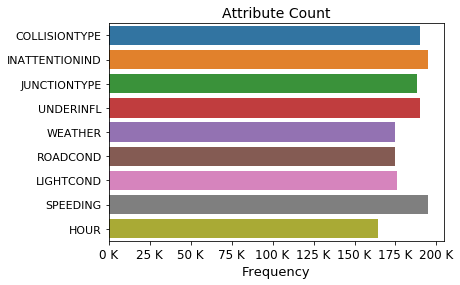

In [13]:
Attribute_count = Collisions_df[Attributes].describe(include="all").transpose()["count"]
Attribute_count_plot = sns.barplot(Attribute_count.values,Attribute_count.index)

xlabels = ['{:,.0f}'.format(x) + ' K' for x in Attribute_count_plot.get_xticks()/1000]
Attribute_count_plot.set_xticklabels(xlabels)
plt.title("Attribute Count")
plt.xlabel("Frequency")

print("The number of valid entries for each attribute after cleaning.")

We can now remove instances where attributes are undefined (nan):

In [14]:
Collisions_df.dropna(subset=Attributes, inplace = True)

There are [48394, 96951] instances of Severity type ['Injury Collision' 'Property Damage Only Collision'] respectivley.


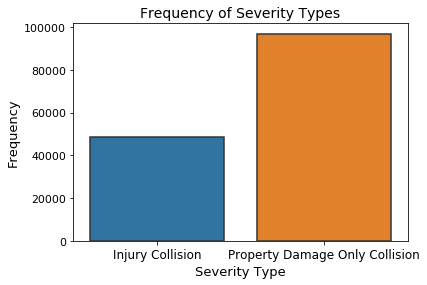

In [15]:
Severity_type = Collisions_df["SEVERITYDESC"].unique() # get all unique Severity Codes
# use list comprehension to count the frequency of each Severity Code in everity_type
Severity_Count = [(Collisions_df["SEVERITYDESC"] == S).sum() for S in Severity_type]
Overall_Injury_Prop = Severity_Count[0]/sum(Severity_Count)
# plot the frequency of each Severity Code
Severity_plot = sns.barplot(x=Severity_type,y=Severity_Count, linewidth = 1.5, edgecolor="0.2")
plt.title("Frequency of Severity Types")
plt.ylabel("Frequency")
plt.xlabel("Severity Type")
print("There are", Severity_Count, "instances of Severity type", Severity_type, "respectively.")

## Balancing the Dataset

From the previous plot we can see that the data set is not balanced. This needs to be addressed before applying the machine learning algorithms in order to properly address the predictive capabilities of the machine learning models.

We have a large amount of data and so we undersample the majority severity type (Property Damage Only Collision). Due to the large minority data set the trends present in the full data set should be preserved. 

In [16]:
from sklearn.utils import resample

In [17]:
#seperate the dataframe based on SEVERITYCODE
Property_Collisions_df = Collisions_df[Collisions_df["SEVERITYCODE"]==1]
Injury_Collisions_df = Collisions_df[Collisions_df["SEVERITYCODE"]==2]

In [18]:
Property_Collisions_downsampled = resample(Property_Collisions_df,
                                replace = False, # sample without replacement
                                n_samples = len(Injury_Collisions_df), # match minority n
                                random_state = 27) # reproducible results
# combine minority and downsampled majority
DS_Collisions_df = pd.concat([Property_Collisions_downsampled, Injury_Collisions_df])

There are [48394, 48394] instances of Severity type ['Property Damage Only Collision' 'Injury Collision'] respectivley.


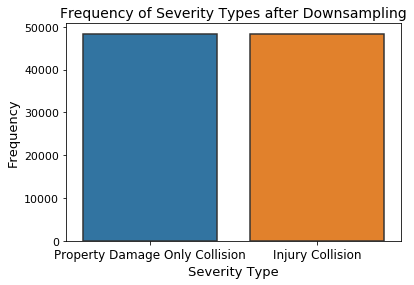

In [19]:
Severity_type = DS_Collisions_df["SEVERITYDESC"].unique() # get all unique Severity Codes
# use list comprehension to count the frequency of each Severity Code in everity_type
Severity_Count = [(DS_Collisions_df["SEVERITYDESC"] == S).sum() for S in Severity_type]

# plot the frequency of each Severity Code
Severity_plot = sns.barplot(x=Severity_type,y=Severity_Count, linewidth = 1.5, edgecolor="0.2")
plt.title("Frequency of Severity Types after Downsampling")
plt.ylabel("Frequency")
plt.xlabel("Severity Type")
print("There are", Severity_Count, "instances of Severity type", Severity_type, "respectivley.")

## Relabelling the Data

In this dataset the SEVERITYCODE takes values of (1,2) for the machine learning algorithms implemented later such as logistic regression is these will be redefined as (0,1) respectivley in the attribute SEVERITYCODE_MOD.

In [20]:
# subtract 1 from SEVERITYCODE so that .mean() gives the proportion of SEVERITYCODE == 2 (Injury Collision)
DS_Collisions_df["SEVERITYCODE_MOD"] = DS_Collisions_df["SEVERITYCODE"]-1

## Annual and Monthly Variation in Incident Frequency and Type


(A) There doesn't appear to be any clear correlation with the number of instances in each year.
    We should note that clearly the data is incomplete for 2020.

(B) There doesn't appear to be any seasonal dependence in the frequency of incidents.The absense of any seasonal
    dependence is somewhat suprising given that variable weather conditions, daylight hours etc.



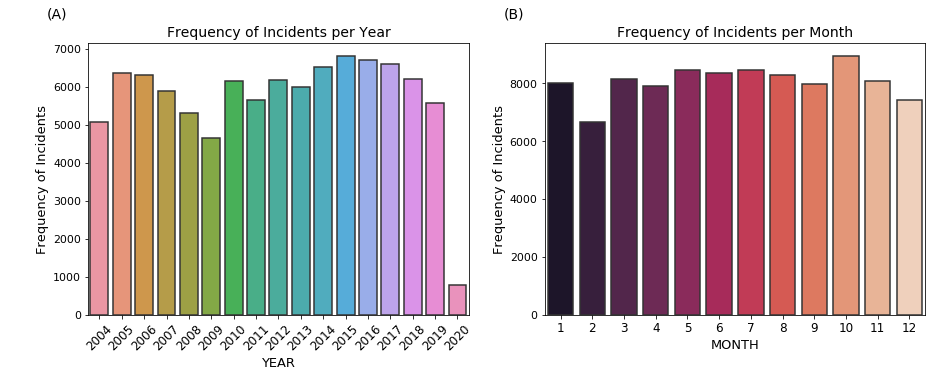

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15, 5)) #set up subplots

# count the number of incidents in each year
Yr_Incident_plot = sns.barplot(x="YEAR",y="SEVERITYCODE", data = DS_Collisions_df.groupby("YEAR").count().reset_index(),\
                            linewidth = 1.5, edgecolor="0.2", ax=ax[0])
ax[0].set_xticklabels(Yr_Incident_plot.get_xticklabels(), rotation=45)
ax[0].set(title="Frequency of Incidents per Year")
ax[0].set(ylabel="Frequency of Incidents")
ax[0].annotate("(A)", xy = (0.05,0.95), xycoords = "figure fraction", fontsize = 14)

# count the number of incidents in each year
Mh_Incident_plot = sns.barplot(x="MONTH",y="SEVERITYCODE", data = DS_Collisions_df.groupby("MONTH").count().reset_index(),\
                            linewidth = 1.5, edgecolor="0.2", ax=ax[1], palette="rocket") #, palette="cubehelix"

ax[1].set(title="Frequency of Incidents per Month")
ax[1].set(ylabel="Frequency of Incidents")
ax[1].annotate("(B)", xy = (0.54,0.95), xycoords = "figure fraction", fontsize = 14)

print("\n(A) There doesn't appear to be any clear correlation with the number of instances in each year.\n    We should note that clearly the data is incomplete for 2020.")
print("\n(B) There doesn't appear to be any seasonal dependence in the frequency of incidents.The absense of any seasonal\n\
    dependence is somewhat suprising given that variable weather conditions, daylight hours etc.\n")


There doesn't appear to be any seasonal dependence in the proportion of incidents classified as an injury collision.
This is again suprising given the variable conditions thoughout the year.

From this cursory analysis the month is probably not useful in predicting the type of collision.



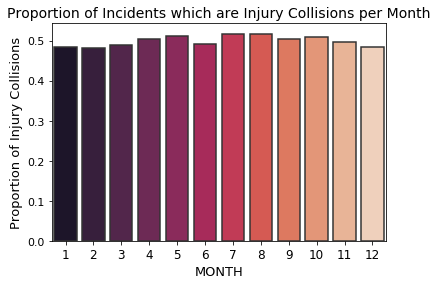

In [22]:
# count the number of incidents in each month
Mh_PropIncident_plot = sns.barplot(x="MONTH",y="SEVERITYCODE_MOD", data = DS_Collisions_df.groupby("MONTH").mean().reset_index(),\
                            linewidth = 1.5, edgecolor="0.2", palette="rocket")
plt.title("Proportion of Incidents which are Injury Collisions per Month")
plt.ylabel("Proportion of Injury Collisions")

print("\nThere doesn't appear to be any seasonal dependence in the proportion of incidents classified as an injury collision.\n\
This is again suprising given the variable conditions thoughout the year.\n\n\
From this cursory analysis the month is probably not useful in predicting the type of collision.\n")

## Dependence of Incident Frequency and Type on Time


(A) There is evidence that there is some variation throughout the day in the frequency of incidents per hour.
    There are relativly few incidents in the early hours of the morning, with local peaks around commuting hours
    (08:00 - 09:00 and 17:00 - 18:00) and a further peak after midnight (24:00 - 01:00). We could speculate that
    the origin of this late night peak could be associated with the closing of establishments.

(B) There does appear to be some meaningful variation in the proportion of incidents which are injury collisions.
    The proportion of injury collisions exceed the average daily proportion between 06:00 and 09:00 and then again
    between 13:00 and 19:00

    The hour in which an incidence occurs could therefore be a useful predictor of the type of incident


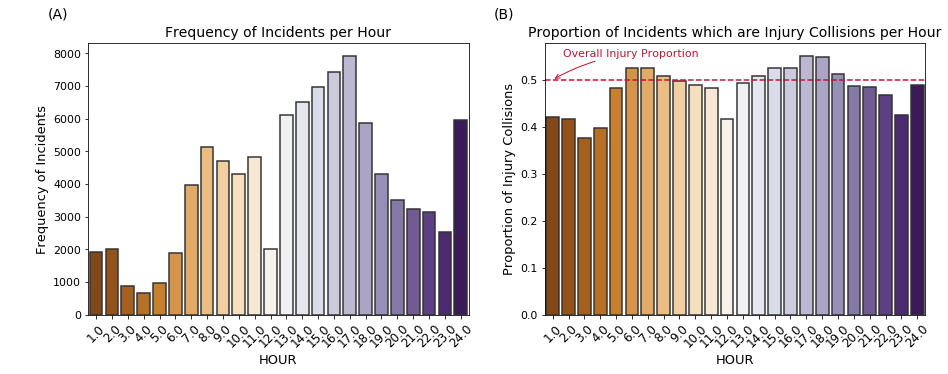

In [23]:
fig, ax = plt.subplots(1,2,figsize=(15, 5)) #set up subplots

Hr_Incident_plot = sns.barplot(x="HOUR",y="SEVERITYCODE", data = DS_Collisions_df.groupby("HOUR").count().reset_index(),\
                            linewidth = 1.5, edgecolor="0.2", palette="PuOr", ax=ax[0])

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set(title="Frequency of Incidents per Hour")
ax[0].set(ylabel="Frequency of Incidents")
ax[0].annotate("(A)", xy = (0.05,0.95), xycoords = "figure fraction", fontsize = 14)

Hr_PropIncident_plot = sns.barplot(x="HOUR",y="SEVERITYCODE_MOD", data = DS_Collisions_df.groupby("HOUR").mean().reset_index(),\
                            linewidth = 1.5, edgecolor="0.2", palette="PuOr", ax=ax[1])

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set(title="Proportion of Incidents which are Injury Collisions per Hour")
ax[1].set(ylabel="Proportion of Injury Collisions")
ax[1].annotate("(B)", xy = (0.52,0.95), xycoords = "figure fraction", fontsize = 14)
ax[1].axhline(0.5, ls='--', color = "#c71035")
ax[1].annotate("Overall Injury Proportion", xy=(0, 0.5),  xycoords='data',
            xytext=(10,23), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.1", color = "#c71035"), fontsize = 11, color = "#c71035")

print("\n(A) There is evidence that there is some variation throughout the day in the frequency of incidents per hour.\n\
    There are relativly few incidents in the early hours of the morning, with local peaks around commuting hours\n\
    (08:00 - 09:00 and 17:00 - 18:00) and a further peak after midnight (24:00 - 01:00). We could speculate that\n\
    the origin of this late night peak could be associated with the closing of establishments.")
print("\n(B) There does appear to be some meaningful variation in the proportion of incidents which are injury collisions.\n\
    The proportion of injury collisions exceed the average daily proportion between 06:00 and 09:00 and then again\n\
    between 13:00 and 19:00\n")
print("    The hour in which an incidence occurs could therefore be a useful predictor of the type of incident")

In [24]:
#alternate view of hour data by incident type (plot B)
#hour_count = sns.countplot(x="HOUR",hue="SEVERITYDESC", data = DS_Collisions_df,\
#                    linewidth = 1.5, edgecolor="0.2", palette="rocket")
#hour_count.set_xticklabels(hour_count.get_xticklabels(), rotation=45)
#print("Incident frequency per hour by Type")

## Attributes

### Visual Assessment

Using the balanced dataset we would expect attributes where there is a discrpency between the frequency of different incident types to be predictive. Conversly an approximatley even distribution between categories of an attribute suggests that the attribute has little or no predictive capability to distinuish between different types of incidents.

Following on from our investigation on the effect of hour, month and year previously; we will first access the other attributes visually:

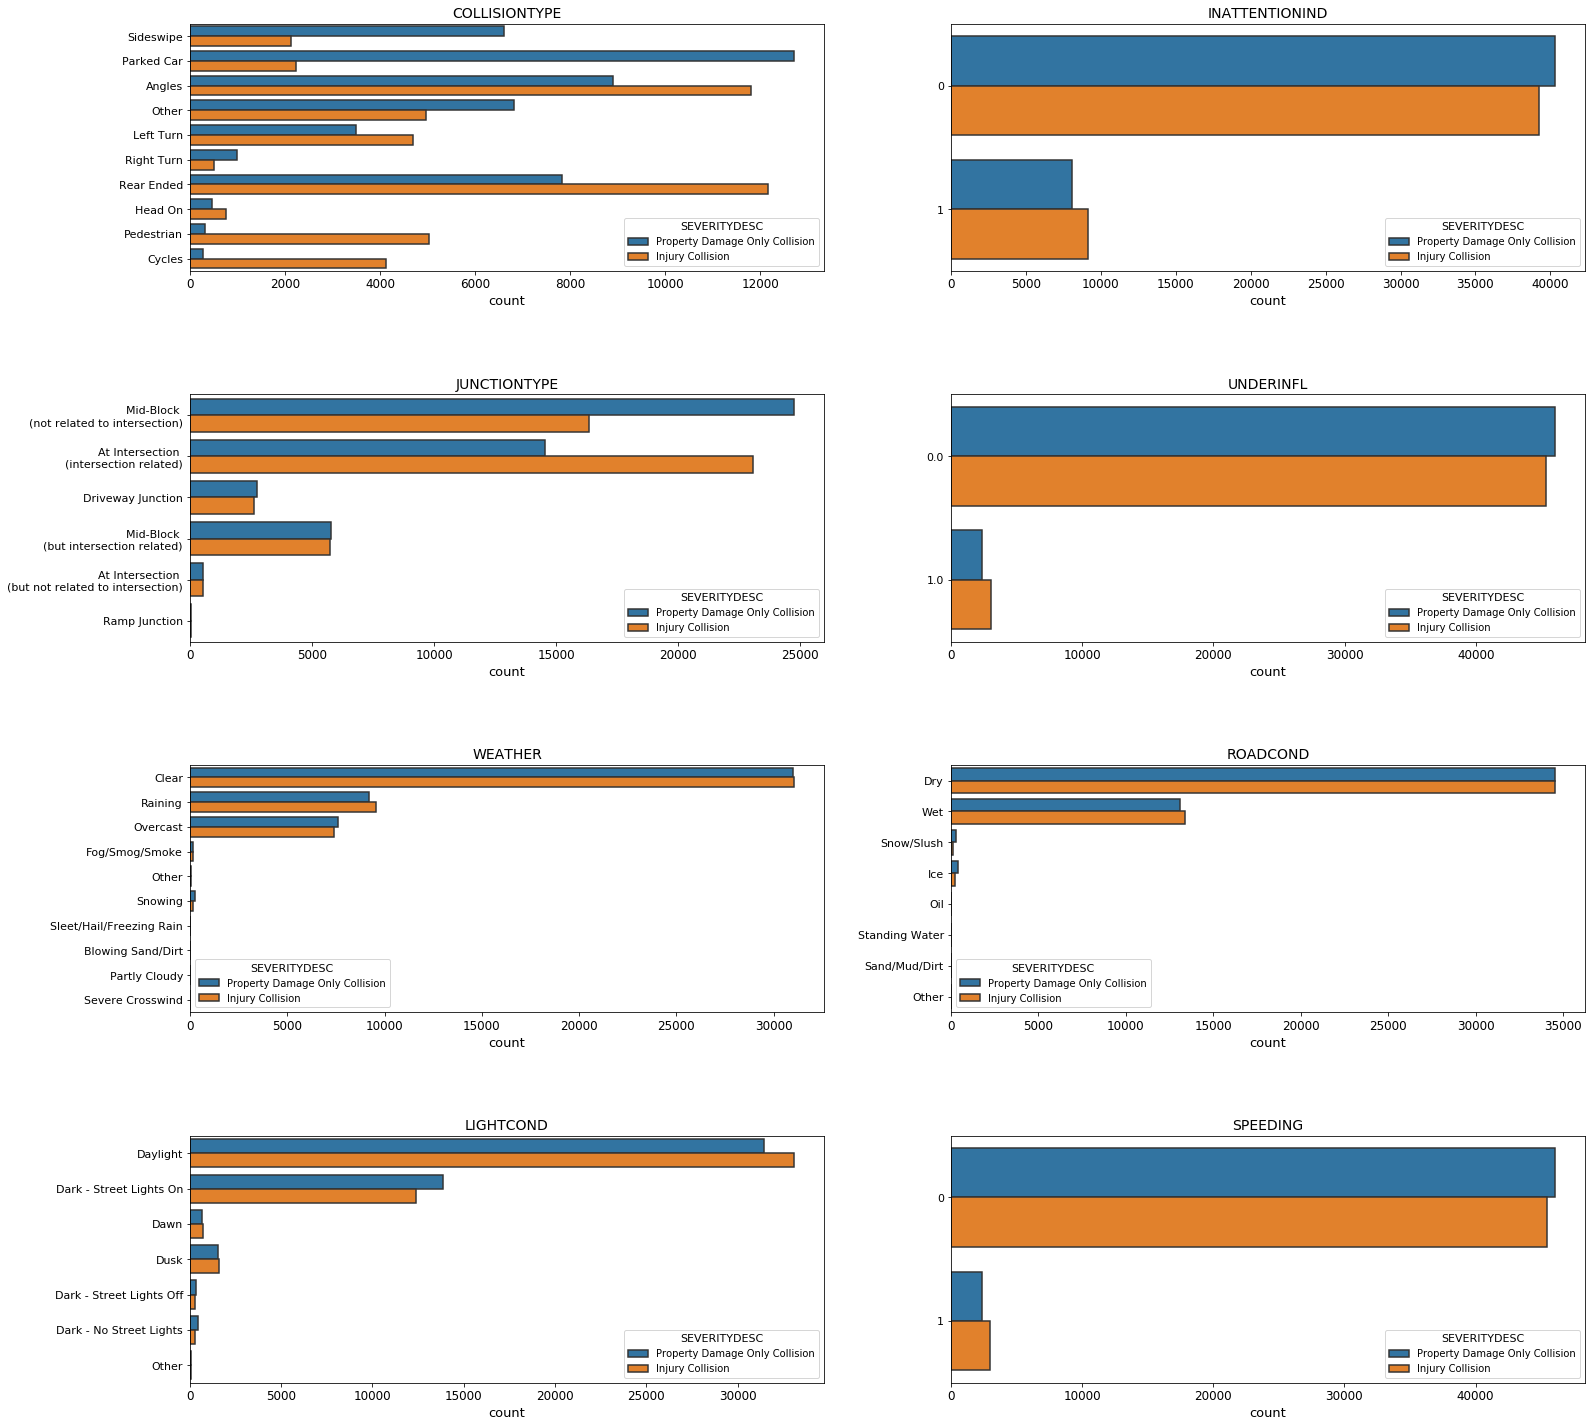

In [25]:
%matplotlib inline
fig, ax = plt.subplots(4,2,figsize=(25, 25)) #set up subplots
plt.subplots_adjust(wspace = 0.2, hspace=0.5)
row = -1
col = -1
for counter, Attribute in enumerate(Attributes[:-1]): #we won't plot the hour attribute as it is easier to see above
    row += 1*(1-counter%2)
    col = counter%2
# count the number of incidents in each year
    p = sns.countplot(y=Attribute, hue ="SEVERITYDESC", data = DS_Collisions_df,\
                            linewidth = 1.5, edgecolor="0.2", ax=ax[row,col])
    #if bracket in ylabel add new line:
    p.set_yticklabels([label.replace('(', '\n(') for label in [item.get_text() for item in p.get_yticklabels()]])
    #ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(), rotation=45)
    ax[row,col].set(title=Attribute)
    ax[row,col].set(ylabel="")

**For the attributes:**
- COLLISIONTYPE
- JUNCTIONTYPE

There are some large discrepancies within categories for the different incident types. We would therefore expect this attributes to be useful predictors of the incident type.

**For the attribute:**
- LIGHTCOND

There are some discrepancies within categories for the different incident types. We would therefore expect this attribute may be a useful predictor of the incident type.

**For the attributes:**
- WEATHER
- ROADCOND
- INATTENTIONIND
- SPEEDING
- UNDERINFL

There similar counts of each incident type for the most of the major categories. These appear to provide less information on the type of incident. This is fairly suprising given that environmental conditions, speeding and being under the influence might be expected to effect the severity of incident but this appears not to be the case.

## Machine Learning Algorithms

In [45]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### One-hot Encoding

Based on the earlier analysis of the different features we will limit our analysis to those features which are more predictive. This is should increase the efficieny of our ML training algorithms and remove obscuring features.

In [83]:
Selected_Attributes = ['COLLISIONTYPE', 'JUNCTIONTYPE', 'LIGHTCOND', "HOUR"]

In [84]:
DS_Collisions_df.reset_index(drop=True, inplace = True)
DS_Collisions_df["HOUR"] = DS_Collisions_df["HOUR"].astype(str) #set hour as string so it can be one hot encoded

In [85]:
X = pd.concat([pd.get_dummies(DS_Collisions_df[Selected_Attributes])], axis=1)
y = DS_Collisions_df["SEVERITYCODE_MOD"]

In [86]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

## Decision Tree

### Training

In [96]:
from sklearn.tree import DecisionTreeClassifier

DTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DTree.fit(X_trainset,y_trainset)
predTree = DTree.predict(X_testset)

### Visulisation

In [88]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

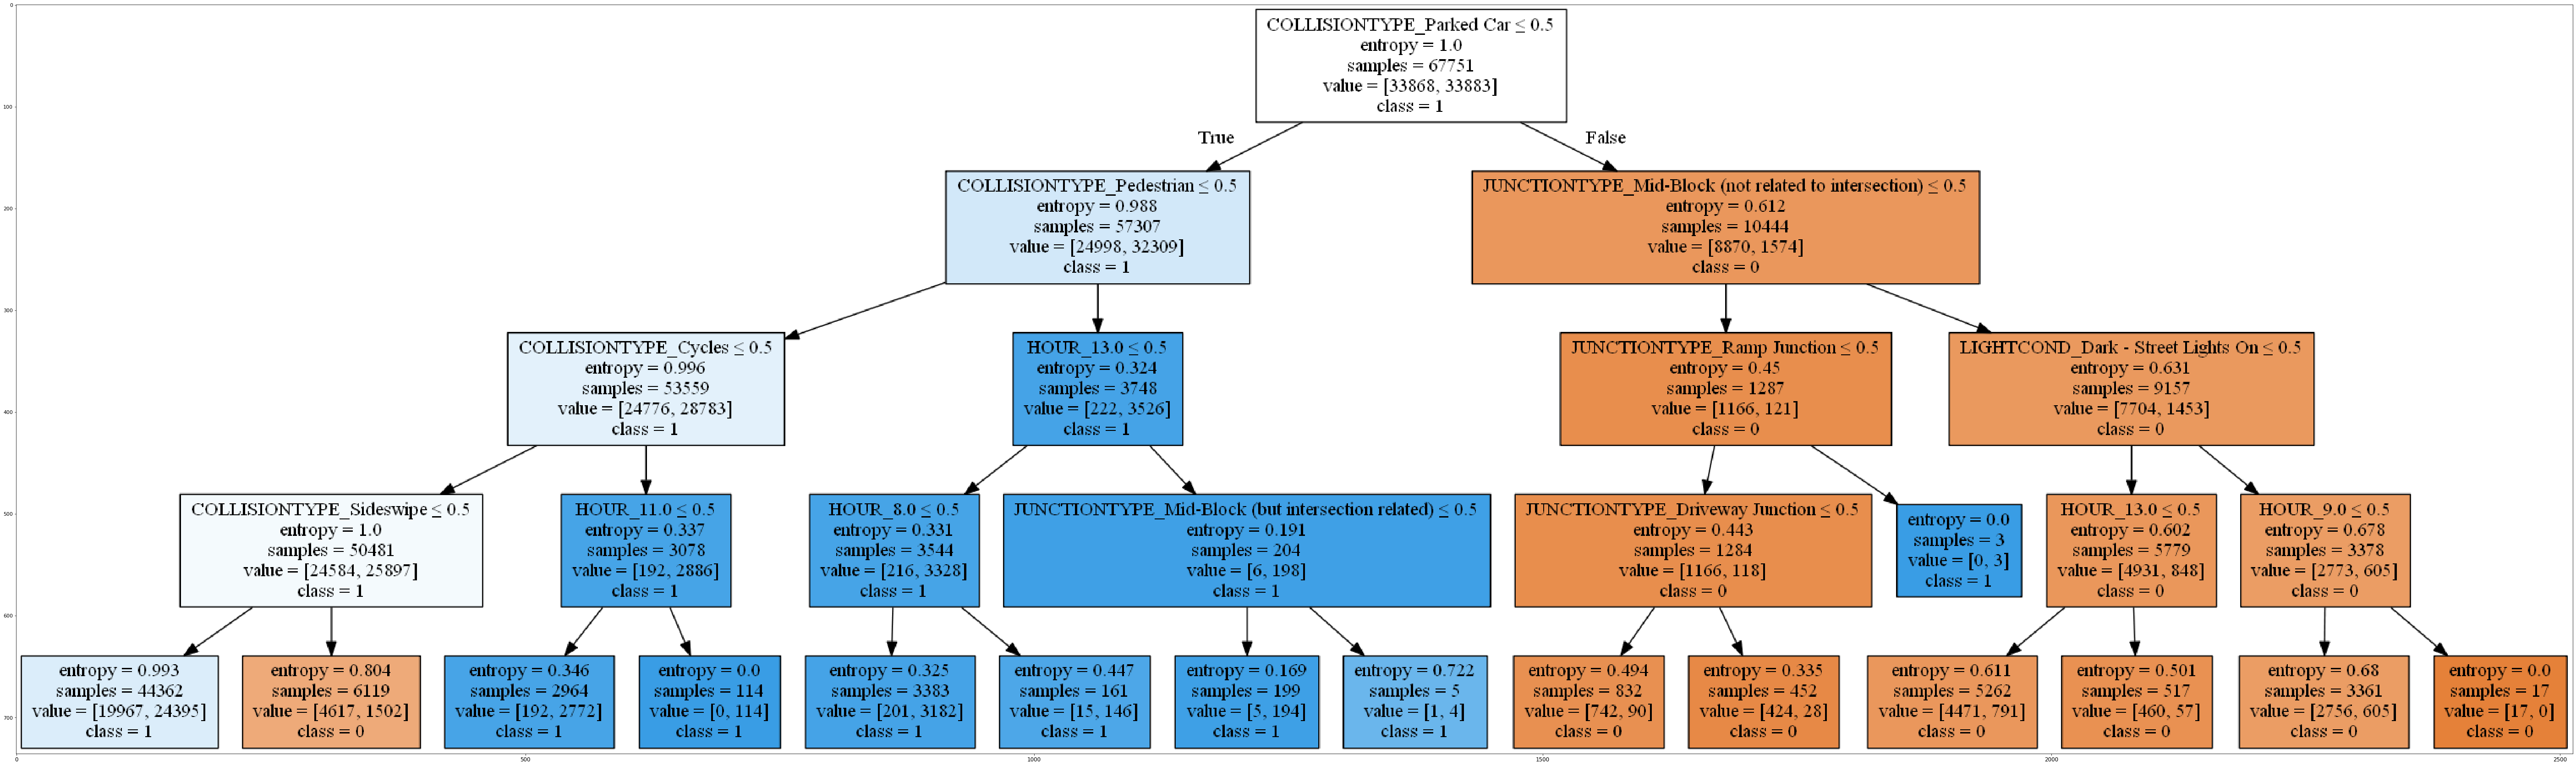

In [97]:
dot_data = StringIO()
filename = "Dtree.png"
featureNames = X.columns
targetNames = y.unique().tolist()
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= ["0","1"], filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Evaluation

Accuracy score: 0.66
f1-score: 0.63

Confusion matrix, without normalization
[[ 5821  8705]
 [ 1278 13233]]


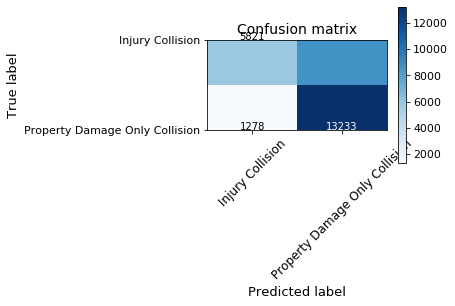

In [90]:
print("Accuracy score: %.2f" % accuracy_score(y_testset, predTree))
print("f1-score: %.2f" % f1_score(y_testset, predTree, average='weighted'))
print("")

cnf_matrix = confusion_matrix(y_testset, predTree)
plot_confusion_matrix(cnf_matrix, classes=Collisions_df["SEVERITYDESC"].unique(),normalize= False,  title='Confusion matrix')

## Logistic Regression

### Training

In [91]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_trainset,y_trainset)
predLR = LR_model.predict(X_testset)

C:\Users\timot\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Evaluation

Accuracy score: 0.68
f1-score: 0.68

Confusion matrix, without normalization
[[ 8167  6359]
 [ 2881 11630]]


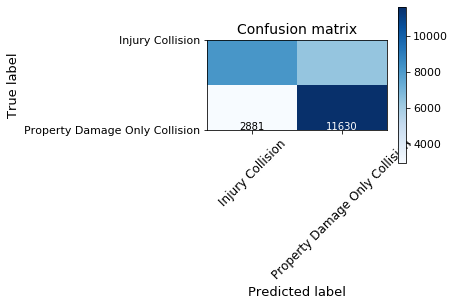

In [92]:
print("Accuracy score: %.2f" % accuracy_score(y_testset, predLR))
print("f1-score: %.2f" % f1_score(y_testset, predLR, average='weighted'))
print("")

cnf_matrix = confusion_matrix(y_testset, predLR)
plot_confusion_matrix(cnf_matrix, classes=Collisions_df["SEVERITYDESC"].unique(),normalize= False,  title='Confusion matrix')

## K-Nearest Neighbours

### Training

In [93]:
from sklearn.neighbors import KNeighborsClassifier

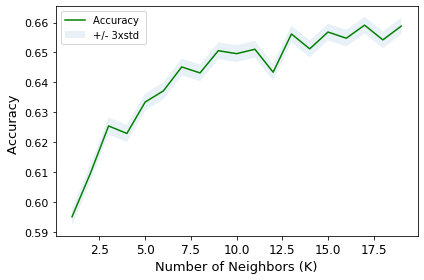

In [94]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_trainset,y_trainset)
    predKNN=neigh.predict(X_testset)
    mean_acc[n-1] = metrics.accuracy_score(y_testset, predKNN)
    std_acc[n-1]=np.std(predKNN==y_testset)/np.sqrt(predKNN.shape[0])
    
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### Evaluation

The best k = 17
Accuracy score: 0.66
f1-score: 0.66

Confusion matrix, without normalization
[[9646 4880]
 [5018 9493]]


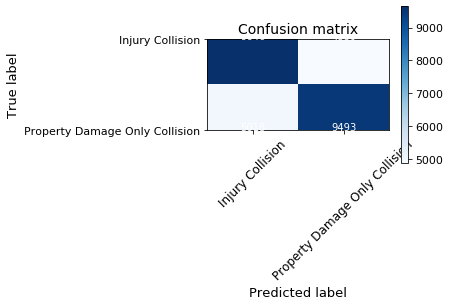

In [95]:
print( "The best k =", mean_acc.argmax()+1) 

neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_trainset,y_trainset)
predKNN=neigh.predict(X_testset)

print("Accuracy score: %.2f" % accuracy_score(y_testset, predKNN))
print("f1-score: %.2f" % f1_score(y_testset, predKNN, average='weighted'))
print("")

cnf_matrix = confusion_matrix(y_testset, predKNN)
plot_confusion_matrix(cnf_matrix, classes=Collisions_df["SEVERITYDESC"].unique(),normalize= False,  title='Confusion matrix')

## Support Vector Machine

### Training

In [99]:
from sklearn import svm

SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X_trainset, y_trainset)
predSVM = SVM_model.predict(X_testset)

C:\Users\timot\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Evaluation

Accuracy score: 0.68
f1-score: 0.68

Confusion matrix, without normalization
[[ 8107  6419]
 [ 2860 11651]]


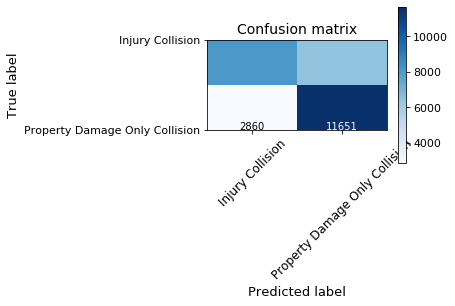

In [100]:
print("Accuracy score: %.2f" % accuracy_score(y_testset, predSVM))
print("f1-score: %.2f" % f1_score(y_testset, predSVM, average='weighted'))
print("")

cnf_matrix = confusion_matrix(y_testset, predSVM)
plot_confusion_matrix(cnf_matrix, classes=Collisions_df["SEVERITYDESC"].unique(),normalize= False,  title='Confusion matrix')

## Conclusions

We have trained several machine learning techniques to classify an incident based on attributes such as the collision type, junction type and time.
The accuracy achieved with each algorithm ≥ 0.66, compared to a base line 0.5.
The best algorithms in terms of performance metrics were logistic regression and SVM. However the algorithm most successful at correctly identifying the more serious class of incidents (incidents with injuries) was KNN.
We will need to engage with discussions to understand what the most important performance metrics are before deploying the chosen algorithm.
